# Extract $^{252}$Cf source activity from (s,d,t) rates

Jan-2, 2022

## imports and defintions

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/mySoftware/Python/'); 
import sys; sys.path.insert(0, '/Users/erezcohen/Desktop/Software/TOFPET2/PETsysAnalysis/Python/'); 
from my_tools               import *; 
from plot_tools             import *;
from my_data_analysis_tools import *;
from PETsys_analysis_tools  import *;

%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Activity from (s,d,t)
use a function compiled by Yuval on Jan-2, 2022

### plot (s,d,t) vs. activity

#### simulation results
The (s,d,t) rates for a simulated 5uCi source from PetsysEventAnalyzer

In [56]:
colors=['royalblue','salmon','forestgreen']
labels=['Singles','Doubles','Triples']

In [59]:
Activity_main_sim = 5    # uCi
s_main_sim        = 1458 # Hz
s_main_sim_err    = 8    # Hz
d_main_sim        = 49.2 # Hz
d_main_sim_err    = 1.3  # Hz
t_main_sim        = 1.2  # Hz
t_main_sim_err    = 0.2  # Hz

In [75]:
# arrays
A_arr             = np.linspace(0.5,10.,100)
s_arr_sim         = s_main_sim    *A_arr/Activity_main_sim
s_arr_sim_err     = s_main_sim_err*A_arr/Activity_main_sim
d_arr_sim         = d_main_sim    *A_arr/Activity_main_sim
d_arr_sim_err     = d_main_sim_err*A_arr/Activity_main_sim
t_arr_sim         = t_main_sim    *A_arr/Activity_main_sim
t_arr_sim_err     = t_main_sim_err*A_arr/Activity_main_sim


#### measured data

In [76]:
s     = 1436. # Hz
s_err = 4.    # Hz
d     = 49.6  # Hz
d_err = 0.7   # Hz
t     = 1.1   # Hz
t_err = 0.1   # Hz

measured_rates     = [s,d,t]
measured_rates_err = [s_err,d_err,t_err]

In [82]:
def find_best_A_value( A_arr, sim_arr,sim_arr_err, Rmeas ):
    # find best A value for the measured rate
    Rdiff_min = 10000
    for j in range(len(A_arr)): #{
        Rsim,Rsim_err = sim_arr[j],sim_arr_err[j]
        if ( np.abs(Rsim - Rmeas) < Rdiff_min ):#{ 
            Rdiff_min = np.abs(Rsim - Rmeas)
            Adiff_min = A_arr[j]
        #}
    #}
    return Adiff_min;

#### plot

saved /Users/erezcohen/Desktop/Projects/FNMC/BoxSi/papers/BoxSi_p2.2_NIM_paper/Figures/rates_vs_activity.pdf


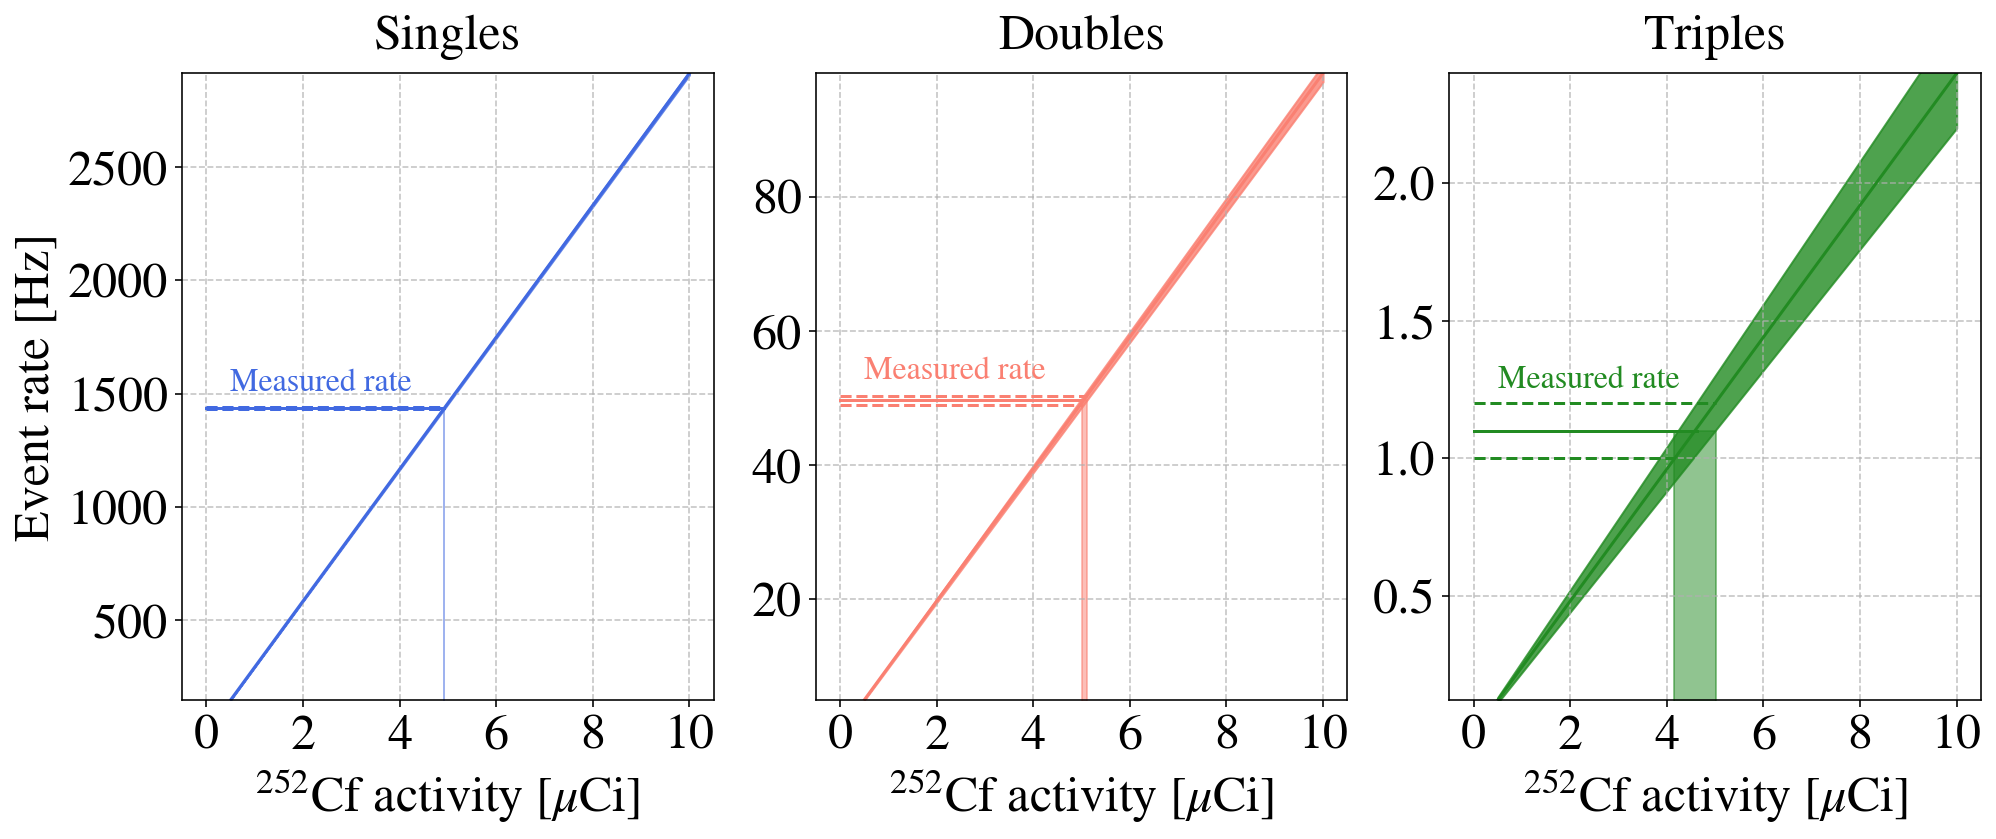

In [109]:
fig = plt.figure(figsize=(14,6));

for (sim_arr,sim_arr_err,
     label,color,i,
     Rmeas,Rmeas_err) in zip([s_arr_sim,d_arr_sim,t_arr_sim],
                                           [s_arr_sim_err,d_arr_sim_err,t_arr_sim_err],
                                           labels, 
                                           colors,
                                             range(3),
                                                            measured_rates,measured_rates_err):
    ax= fig.add_subplot(1,3,i+1)
    ax.plot( A_arr, sim_arr, color=color, label=label)
    ax.fill_between( A_arr, sim_arr-sim_arr_err/2, sim_arr+sim_arr_err/2, color=color, label=None, alpha=0.8)

    Abest = find_best_A_value( A_arr, sim_arr,sim_arr_err, Rmeas )
    Aup   = find_best_A_value( A_arr, sim_arr,sim_arr_err, Rmeas+Rmeas_err )
    Adw   = find_best_A_value( A_arr, sim_arr,sim_arr_err, Rmeas-Rmeas_err )

    ax.plot( [0, Abest] ,  [Rmeas,Rmeas], '-',  color=color, label='None')
    ax.plot( [0, Adw] ,    [Rmeas-Rmeas_err,Rmeas-Rmeas_err], '--',  color=color, label='None')
    ax.plot( [0, Aup] ,    [Rmeas+Rmeas_err,Rmeas+Rmeas_err], '--',  color=color, label='None')
    ax.fill_betweenx( [0,Rmeas], [Adw, Adw],[Aup,Aup], color=color, alpha=0.5)
    # ax.fill_between( [0, Aup], [Rmeas-Rmeas_err,Rmeas-Rmeas_err], [Rmeas+Rmeas_err,Rmeas+Rmeas_err], color=color, alpha=0.5)
    # ax.plot( [Abest, Abest], [0,Rmeas],     '--', color=color, label='None')

    # text
    xtext = 0.5
    ytext = Rmeas*1.05 +  Rmeas_err 
    ax.text( xtext, ytext,'Measured rate',fontsize=16, color=color )

    set_axes(ax,'$^{252}$Cf activity [$\mu$Ci]',
             'Event rate [Hz]' if i==0 else '',title=label,ylim=(np.min(sim_arr),np.max(sim_arr)),
             do_add_grid=True,do_add_legend=False)
    
plt.tight_layout()
save_figure(filename='/Users/erezcohen/Desktop/Projects/FNMC/BoxSi/papers/BoxSi_p2.2_NIM_paper/Figures/rates_vs_activity.pdf')

### extract estimated activity for measured data

In [19]:
def estimate_252Cf_activitiy_from_sdt(sdt, delta_sdt,
                                      fit_res      = [293.98351745,  10.69035434], 
                                      sdt_sim      = [1458., 49.2, 1.2],
                                      delta_sdt_sim= [8.,    1.3,  0.2]
                                      # Yuval' results:
                                      # sdt_sim      = [1.480901e+03, 1.321711e+02, 6.183223e+00],
                                      # delta_sdt_sim= [7.449522e+00,2.225531e+00,4.813632e-01]
                                     ):
    """
    Estimates the activity in muCuire based on the simulation. 
    Returns the estimated activity based on the singles rates.
    and assigns a probability value for the S/D and S/T ratio vs. the simulation results for 5 micro Curie.

    
    
    input
    ------
    s, d, t      rates in [Hz]
    
    return
    ---------
    activity     in [uCi]


    """
    from scipy.stats import chi2

    
    s,d,t = sdt[0],sdt[1],sdt[2]
    ds,dd,dt = delta_sdt[0],delta_sdt[1],delta_sdt[2]
    
    s_sim,d_sim,t_sim = sdt_sim[0],sdt_sim[1],sdt_sim[2]
    ds_sim , dd_sim, dt_sim = delta_sdt_sim[0],delta_sdt_sim[1],delta_sdt_sim[2]
    
    # (A) estimate activity form singles-rate
    est_activity = (s- fit_res[1])/fit_res[0]
    
    d_est,d_est_err = d_sim/s_sim*s, dd_sim/s_sim*s #Assumes singles uncertenity is much lower then doubles, assumes lineraity as well
    t_est, t_est_err = t_sim/s_sim*s, dt_sim/s_sim*s #Assumes singles uncertenity is much lower then triples, assumes lineraity as well
    
    chisq = np.abs(d_est-d)/np.sqrt(d_est_err**2+dd**2)+np.abs(t_est-t)/np.sqrt(t_est_err**2+dt**2)
    P_prob = 1-chi2.cdf(chisq,2)
    # print (f'P prob: {P_prob}')
    return est_activity, P_prob    

In [24]:
A,Pval = estimate_252Cf_activitiy_from_sdt( [s, d, t] , [s_err, d_err, t_err])
Aup,Pval_up = estimate_252Cf_activitiy_from_sdt( [s+s_err, d, t] , [s_err, d_err, t_err])
Adw,Pval_dw = estimate_252Cf_activitiy_from_sdt( [s-s_err, d, t] , [s_err, d_err, t_err])

A_errup = Aup - A
A_errdw = A - Adw


print('Activity: %.2f'%A,'uCi +%.2f'%A_errup,'-%.2f'%A_errdw,', P(value):%.2f'%Pval)

Activity: 4.85 uCi +0.01 -0.01 , P(value):0.56


## Check other options to test that the mechanism works properly

In [28]:
s     = 1220. # Hz
A,Pval = estimate_252Cf_activitiy_from_sdt( [s, d, t] , [s_err, d_err, t_err])
Aup,Pval_up = estimate_252Cf_activitiy_from_sdt( [s+s_err, d, t] , [s_err, d_err, t_err])
Adw,Pval_dw = estimate_252Cf_activitiy_from_sdt( [s-s_err, d, t] , [s_err, d_err, t_err])
A_errup = Aup - A
A_errdw = A - Adw
print('Activity: %.2f'%A,'uCi +%.2f'%A_errup,'-%.2f'%A_errdw,', P(value):%.2f'%Pval)

Activity: 4.11 uCi +0.01 -0.01 , P(value):0.03


In [29]:
s     = 1436. # Hz
d     = 39.6  # Hz
A,Pval = estimate_252Cf_activitiy_from_sdt( [s, d, t] , [s_err, d_err, t_err])
Aup,Pval_up = estimate_252Cf_activitiy_from_sdt( [s+s_err, d, t] , [s_err, d_err, t_err])
Adw,Pval_dw = estimate_252Cf_activitiy_from_sdt( [s-s_err, d, t] , [s_err, d_err, t_err])
A_errup = Aup - A
A_errdw = A - Adw
print('Activity: %.2f'%A,'uCi +%.2f'%A_errup,'-%.2f'%A_errdw,', P(value):%.2f'%Pval)

Activity: 4.85 uCi +0.01 -0.01 , P(value):0.04
